# Unityに送信する

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skvideo.io import vread
import moviepy.editor as mpy
from tqdm import tqdm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from IPython.display import Image


def npy_to_gif(npy, filename):
    clip = mpy.ImageSequenceClip(list(npy), fps=10)
    clip.write_gif(filename)

# 素材
vid = vread("src/shisa.mp4")

# アルコマーカー
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco = cv2.aruco.drawMarker(aruco_dict, 0, 128)

# カメラの設定
marker_length = 0.07 # [m] ### 注意！
mtx = np.load("camera/mtx.npy")
dist = np.load("camera/dist.npy")

### カメラの位置姿勢の計算

In [2]:
def kakou(frame, corner, scale):
    scale = scale * 0.25 #  0.125
    _frame = cv2.resize(frame, (int(1080 * scale), int(1920 * scale)))
    cx, cy = (np.mean(corner, axis=1)  * scale).squeeze().astype(np.int).tolist()
    _h, _w = _frame.shape[:2] # 320, 180
    
    if cx >= _w - cx:
        w = cx * 2
        left = 0
    else:
        w = (_w - cx) * 2
        left = w - _w
    
    if cy >= _h - cy:
        h = cy * 2
        top = 0
    else:
        h = (_h - cy) * 2
        top = h - _h

    frame = np.zeros([h, w, 4]).astype(np.uint8)
    _frame = cv2.cvtColor(_frame, cv2.COLOR_RGB2RGBA)
    frame[top:top+_h, left:left+_w] = _frame
    
    hh, ww = 400, 200
    frame2 = np.zeros([hh, ww, 4]).astype(np.uint8)
    _h, _w = frame.shape[:2]
    left, top = int((ww- _w) / 2), int((hh - _h) / 2)
    frame2[top:top+h, left:left+w] = frame
    return frame2

In [3]:
XYZ = []
RPY = []
frames = []

for frame in vid[:500:5]:  # 全部処理すると重いので…
    frame = frame[...,::-1]  # BGR2RGB
    corners, ids, _ = cv2.aruco.detectMarkers(frame, aruco_dict)

    if len(corners) == 0:
        continue

    rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corners, marker_length, mtx, dist)

    R = cv2.Rodrigues(rvec)[0]  # 回転ベクトル -> 回転行列
    R_T = R.T
    T = tvec[0].T
    scale = np.sum(T**2)**0.5
    
    frame = kakou(frame, corners[0], scale)
    frames.append(frame)

    xyz = np.dot(R_T, - T).squeeze()
    XYZ.append(xyz)

    rpy = np.deg2rad(cv2.RQDecomp3x3(R_T)[0])
    RPY.append(rpy)

cv2.destroyAllWindows()

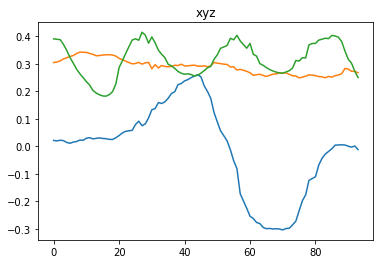

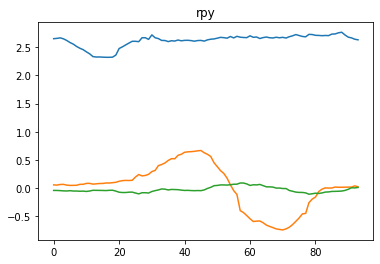

In [4]:
plt.title("xyz"); plt.plot(XYZ); plt.show()  # 青:x, 橙:y, 緑:z
plt.title("rpy"); plt.plot(RPY); plt.show()  # 青:r, 橙:p, 緑:y

In [5]:
# np.save("data/XYZ.npy", np.array(XYZ))
# np.save("data/RPY.npy", np.rad2deg(np.array(RPY)))

In [6]:
# for t, frame in enumerate(frames):
#     cv2.imwrite("data/shisa{:04}.png".format(t), frame)

In [7]:
frame = cv2.imread("data/shisa0000.png", cv2.IMREAD_UNCHANGED)
frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGBA)

img_str = cv2.imencode(".png", frame)[1].tostring()
print(type(img_str))

<class 'bytes'>


(400, 200, 4)


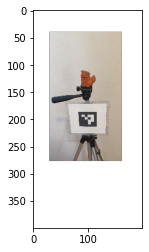

In [8]:
nparr = np.fromstring(img_str, np.uint8)
img_np = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)
print(img_np.shape)

plt.imshow(img_np)
plt.show()

In [9]:
import glob

frames = []
for file in sorted(glob.glob("data/shisa*")):
    frame = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2RGBA)
    frames.append(frame)

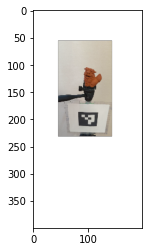

In [10]:
plt.imshow(frame)
plt.show()

In [12]:
len(img_str.split())

1833